In [59]:
import numpy as np
from docplex.mp.model import Model
from docplex.mp.model_reader import ModelReader
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer

from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict
from itertools import combinations
from scipy.sparse import coo_matrix

from qiskit import transpile, QuantumCircuit
# from qiskit.primitives import Estimator, Sampler
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import hellinger_fidelity, SparsePauliOp
from qiskit.result import sampled_expectation_value
from qiskit_aer import AerSimulator

from cd_coefficients import eval_A, eval_B, eval_C, eval_D, first_order_cd_coeff
from scheduling_function import f, df
from bias_field import eval_hb, gs_rotation_angle
from dcqo import dcqo_circ, bf_dcqo_circ


import networkx as nx
import semi_symmetry as ss

## Load problem instance

In [60]:
path = "/Users/vaibhawkumar/vaibhaw/projects/algos/Client-Moderna-Optimization/lp_G0_lp_c/seq_1314_c.lp"
mod = Model()
mod = ModelReader.read_model(path)

#convert linear program to qubo
qp = from_docplex_mp(mod)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
cost_operator, offset = qubo.to_ising()

# convert QP to a upper triangular QUBO matrix
Q = qubo.objective.quadratic.to_array(symmetric=False)
Q += np.identity(Q.shape[0])*qubo.objective.linear.to_array()
print(Q.shape)

(50, 50)


## Reduce graph density

In [71]:
Q_mod = ss.factoring_out_semi_symmetries(Q, num_ancillas=50, z=np.sum(np.abs(Q)))

N = Q.shape[0]
density = np.count_nonzero(np.triu(Q)) / (N+N*(N-1)//2) * 100
print(f"Density (original): {density:.3f}%")

N_mod = Q_mod.shape[0]
density_mod = np.count_nonzero(np.triu(Q_mod)) / (N_mod+N_mod*(N_mod-1)//2) * 100
print(f"Density (mod): {density_mod:.3f}%")

Density (original): 74.980%
Density (mod): 8.804%


## Get new reduced density qubo

In [72]:
def convert_Q2op(Q):
    qubo = QuadraticProgram()
    n = Q.shape[0]
    for i in range(n):
        qubo.binary_var(f'x{i}')
    linear = {}
    quadratic = {}
    for i in range(n):
        for j in range(i, n):
            if i == j:
                linear[f"x{i}"] = Q[i, i]
            else:
                quadratic[f"x{i}", f"x{j}"] = Q[i, j]
    qubo.minimize(linear=linear, quadratic=quadratic)
    qubit_op, offset = qubo.to_ising()
    return qubo, qubit_op, offset

qubo_mod, cost_operator_mod, offset_mod = convert_Q2op(Q_mod)

## BFCD routine:

#### Get edges

In [73]:
def find(s, ch):
    return tuple(i for i, ltr in enumerate(s) if ltr == ch)


def get_edges(op):
    edges = {}
    for elem in op.label_iter():
        edges[find(elem[0], 'Z')] = elem[1].real
        
    return edges

ising_adj = get_edges(cost_operator_mod)

## set BFCD coefficients

In [74]:
num_nodes = Q_mod.shape[0]

In [75]:
# Hi (check this)
hx = -np.ones(num_nodes)
hb = np.zeros(num_nodes)

# Hf
hz = np.zeros(num_nodes)
for key, val in ising_adj.items():
    if len(key) == 1:
        hz[key[0]] = val
        
hz = hz/np.max(np.abs(hz))

row = np.array([e[0] for e in ising_adj.keys() if len(e) > 1])
col = np.array([e[1] for e in ising_adj.keys() if len(e) > 1])
data = np.array([v for k,v in ising_adj.items() if len(k) > 1])

data = data/np.max(np.abs(data))

J = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes))
J2 = coo_matrix((data ** 2, (row, col)), shape=(num_nodes, num_nodes))
J4 = coo_matrix((data ** 4, (row, col)), shape=(num_nodes, num_nodes))

In [76]:
T = 1
A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

N = 100
x = [T * ti / N for ti in range(N + 1)]
y = [f(xi, T) for xi in x]
z = [df(xi, T) for xi in x]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]
w = [2 * abs(v) * w for v, w in zip(a1, z)]

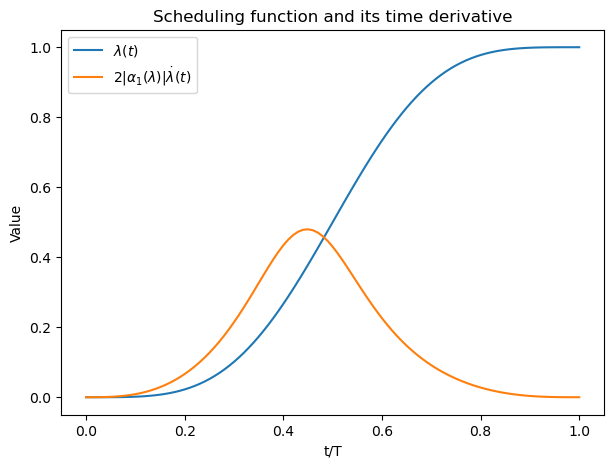

In [77]:
plt.figure(figsize=(7, 5))
plt.plot(x, y)
plt.plot(x, w)

# plt.xticks(rotation=90)
plt.xlabel("t/T")
plt.ylabel("Value")
plt.title("Scheduling function and its time derivative")
plt.legend([r"$\lambda (t)$", r"$2 |\alpha_1 (\lambda)| \dot{\lambda} (t)$"])
plt.show()

In [86]:
# threshold for gate cutoff
threshold = 0.10
shots = 2 ** 13

# MPS simulator
#backend = AerSimulator(method="matrix_product_state")
#sampler = BackendSampler(backend, options={"shots": shots})

T = 1
dt = 0.1
trotter_steps = [1, 2, 3, 4, 5]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

circ = dcqo_circ(num_nodes, hx, hz, row, col, data, y, dy, a1)
circ.measure_all()

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796, 0.2667176834867113, 0.4999999999999998]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688, 2.0755709636919755, 2.4674011002723395]
[-0.07433214734573793, -0.07744041086856317, -0.089031646811417, -0.10459392436237981, -0.08713975613845369]
[0.008705939454740684, 0.06637993339320827, 0.21440363422495812, 0.4341842247703005, 0.430017460346968]


#### AI transpiler

In [87]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_transpiler.ai.routing import AIRouting
 
ai_passmanager = PassManager([
  AIRouting(backend_name="ibm_kyiv", optimization_level=3, layout_mode="optimize", local_mode=True)
])

for i in range(0, 2):
    qc_trans = ai_passmanager.run(circ)
    print(qc_trans.depth(), qc_trans.depth(lambda x:x.operation.num_qubits==2))

1810 1116
1771 1071


from qiskit.transpiler import PassManager
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_transpiler.ai.routing import AIRouting
from qiskit_ibm_transpiler import TranspilerService

transpiler_service = TranspilerService(
            backend_name="ibm_kyiv",
            ai=True,
            optimization_level=3,
    )

for i in range(0, 5):
    qc_trans = transpiler_service.run(circ)
    print(qc_trans.depth(), qc_trans.depth(lambda x:x.operation.num_qubits==2))

#### Optimal QAOA transpiler

In [ ]:
### By Shimada San: Question where is the from optimal_qaoa_transpile import run_optimal_qaoa_transpiler

In [ ]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
 
service = QiskitRuntimeService()
backend = service.backend('ibm_kyiv')
n_shots = 2 ** 20

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(circ)
 
sampler = Sampler(backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.twirling.enable_gates = False
sampler.options.twirling.num_randomizations = "auto"
sampler.options.execution.rep_delay = max(backend.rep_delay_range) #delay between subsequent circuits

job = sampler.run([isa_circuit], shots=n_shots)
result = job.result()
 
# Get results for the first (and only) PUB
pub_result = result[0]
 
print(f" > First ten results: {pub_result.data.meas.get_bitstrings()[:10]}")

/Users/vaibhawkumar/miniconda3/envs/cplex-qiskit/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:903: UserWarning: Your current pending jobs are estimated to consume 782.4158621790854 quantum seconds, but you only have 600 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)
